In [17]:
import tensorflow as tf
print (tf.__version__)
print (tf.keras.__version__)
print (tf.test.is_gpu_available())
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import time
import glob


2.2.0
2.3.0-tf
True


ModuleNotFoundError: ignored

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

4423680/4422102 [==============================] - 0s 0us/step


定义生成器

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

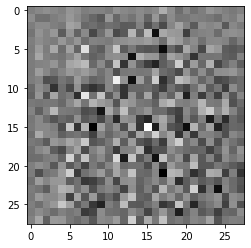

In [3]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape== (None, 7,7,256)

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape==(None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape==(None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation="tanh"))
  assert model.output_shape==(None, 28, 28, 1)

  return model

generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, : ,: ,0], cmap='gray')



定义判别器

In [4]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

定义损失函数和优化器

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

训练模型

In [0]:
 epochs = 100
 noise_dim = 100
 num_examples_to_generator = 16

 seed = tf.random.normal([num_examples_to_generator, noise_dim])

 @tf.function
 def train_step(image):
   noise = tf.random.normal([batch_size, noise_dim])
   
   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     generated_image = generator(noise, training=True)

     real_output = discriminator(image, training=True)
     fake_output = discriminator(generated_image, training=True)

     gen_loss = generator_loss(fake_output)
     disc_loss = discriminator_loss(real_output, fake_output)

   grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
   grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

   generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
   discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))


def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4,4))
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(predictions[i, :,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    #display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    if (epoch + 1) %5 ==0 :
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('time epoch {} is {}'. format(epoch +1, time.time()-start))





进行训练

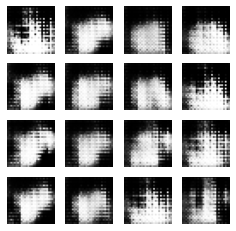

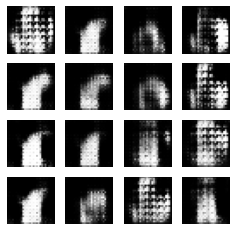

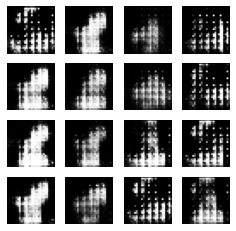

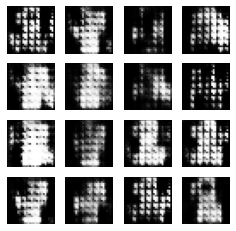

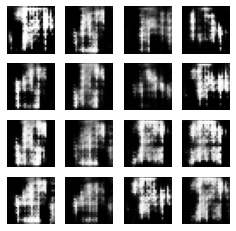

time epoch 5 is 12.937499523162842


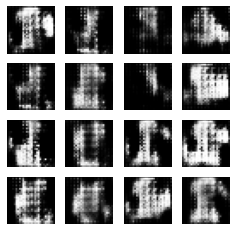

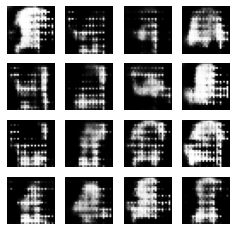

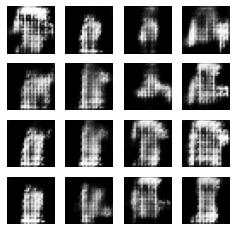

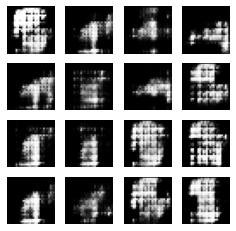

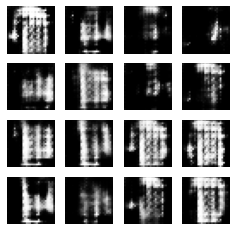

time epoch 10 is 13.276341915130615


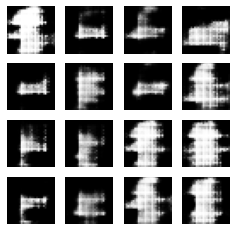

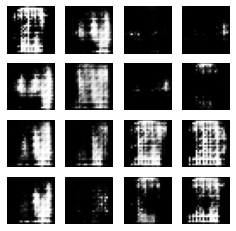

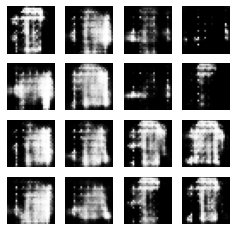

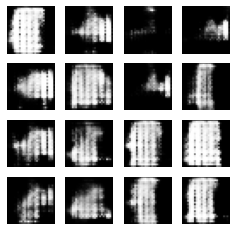

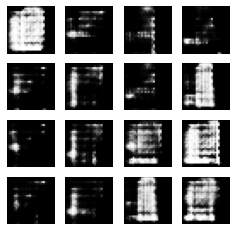

time epoch 15 is 13.240633487701416


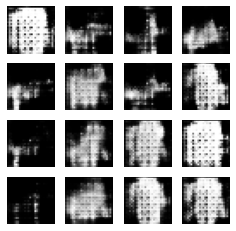

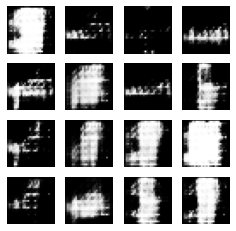

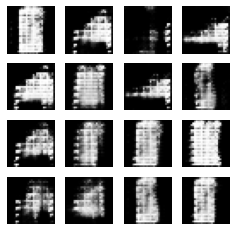

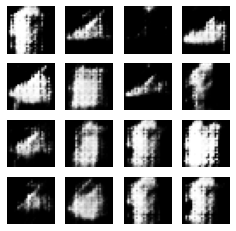

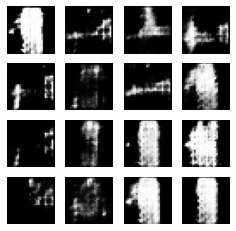

time epoch 20 is 13.172072410583496


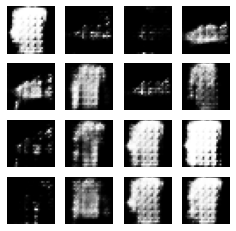

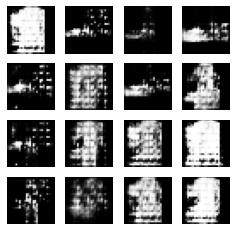

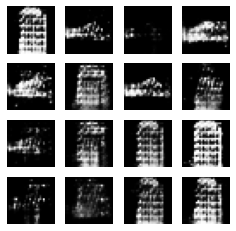

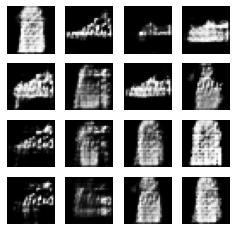

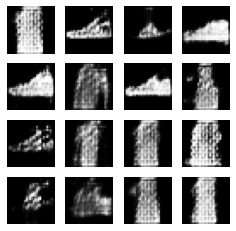

time epoch 25 is 13.120055675506592


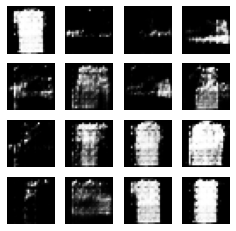

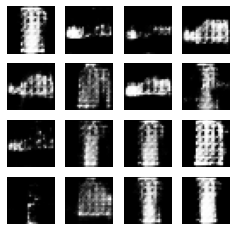

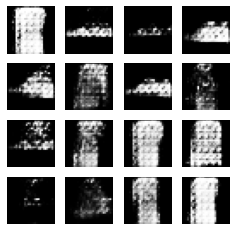

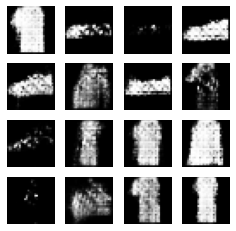

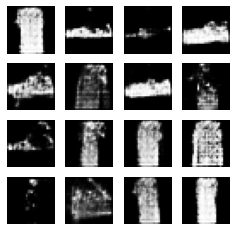

time epoch 30 is 13.086053848266602


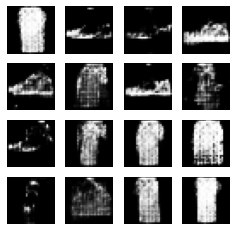

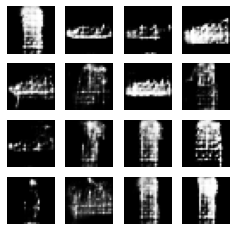

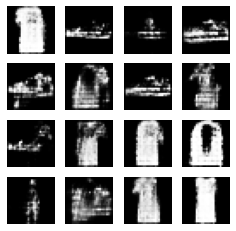

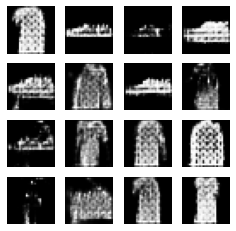

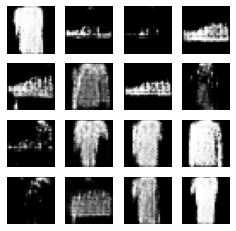

time epoch 35 is 13.206870555877686


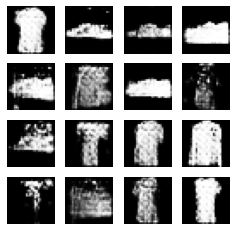

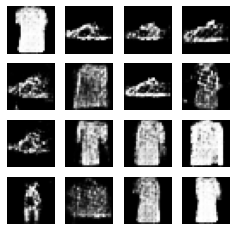

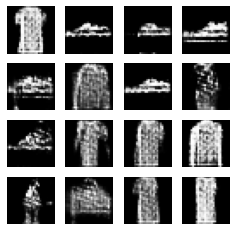

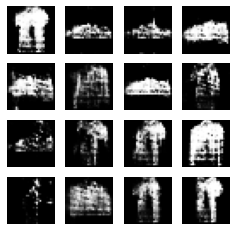

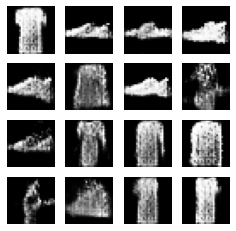

time epoch 40 is 13.27538537979126


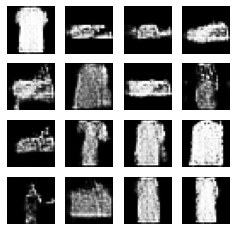

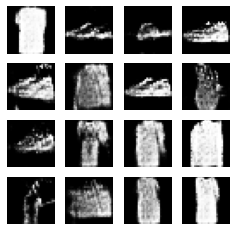

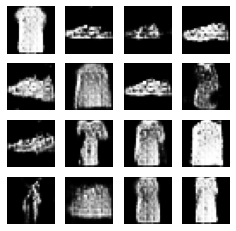

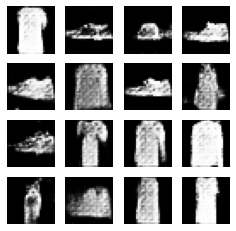

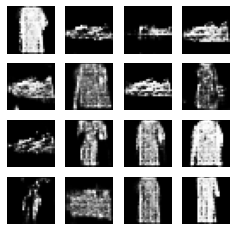

time epoch 45 is 13.208691358566284


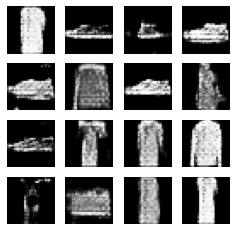

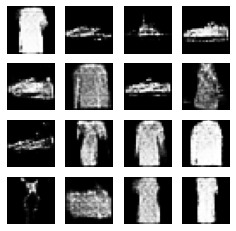

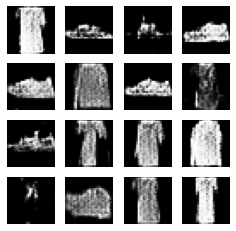

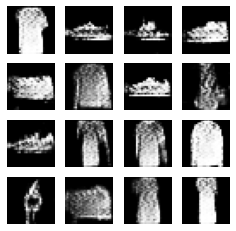

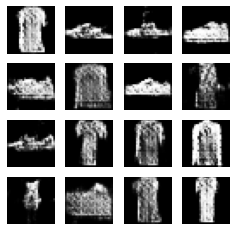

time epoch 50 is 13.152279615402222


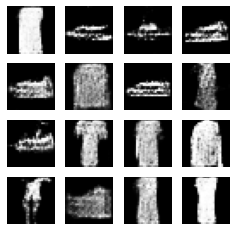

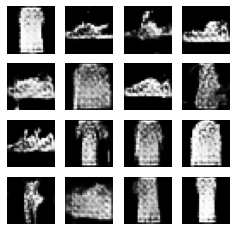

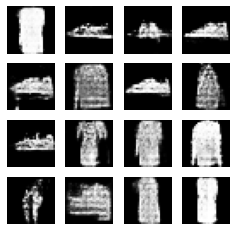

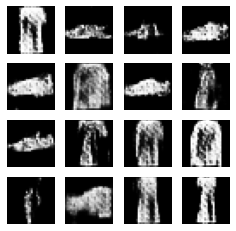

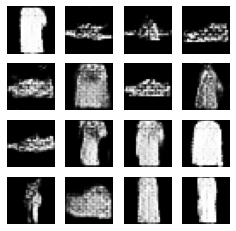

time epoch 55 is 13.130900382995605


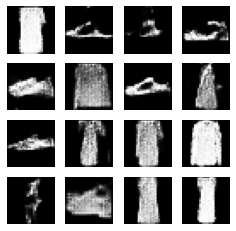

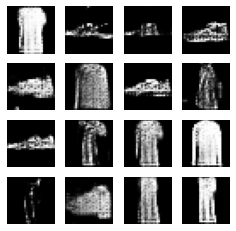

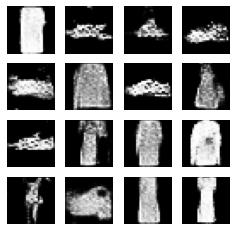

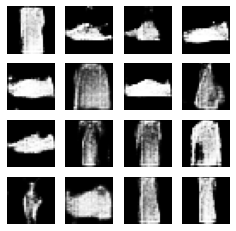

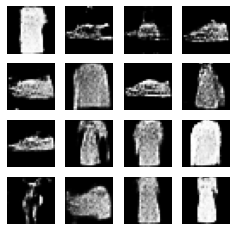

time epoch 60 is 13.214030265808105


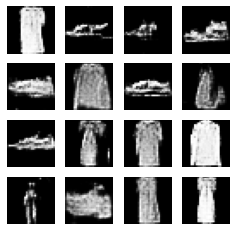

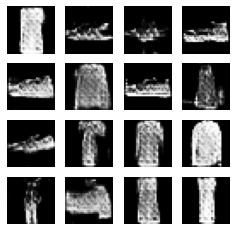

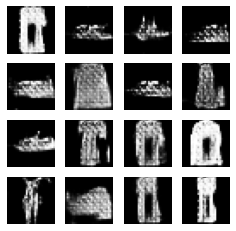

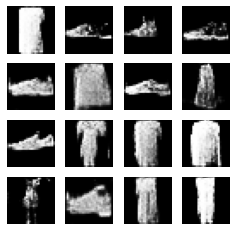

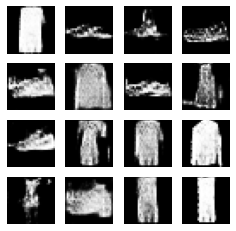

time epoch 65 is 13.280438661575317


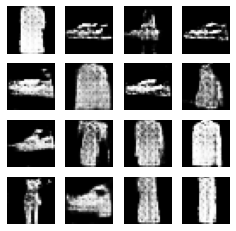

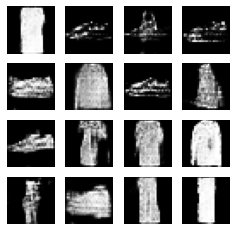

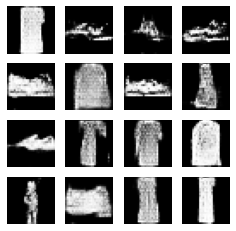

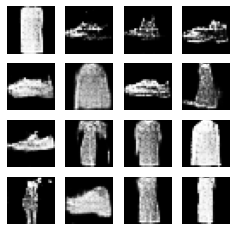

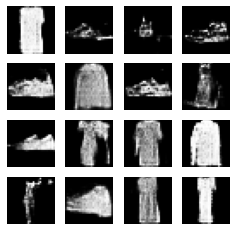

time epoch 70 is 13.302581071853638


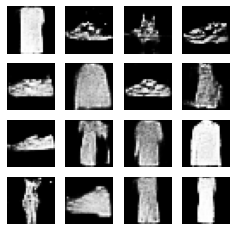

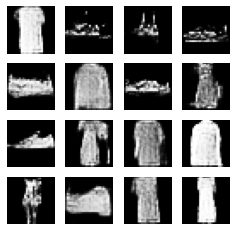

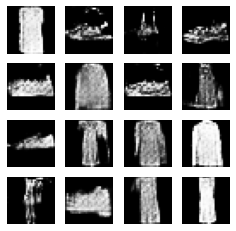

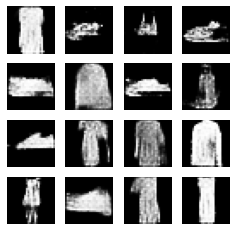

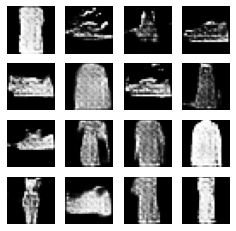

time epoch 75 is 13.098641395568848


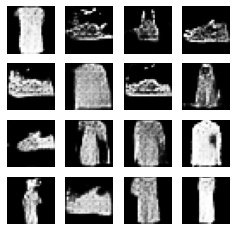

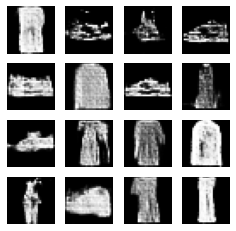

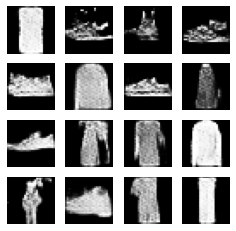

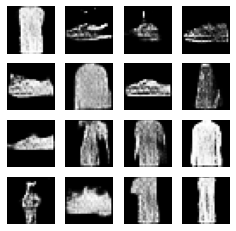

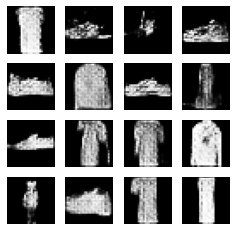

time epoch 80 is 13.096618175506592


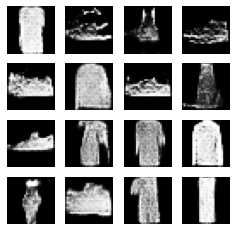

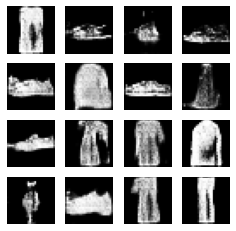

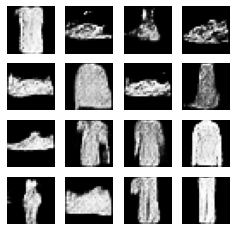

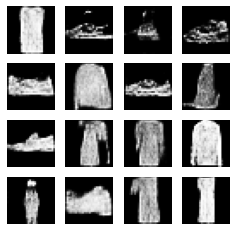

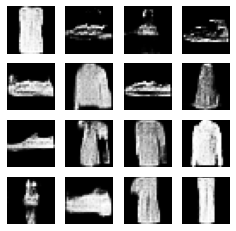

time epoch 85 is 13.25032353401184


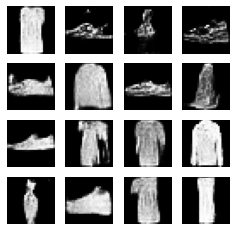

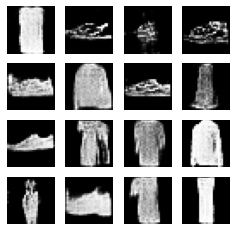

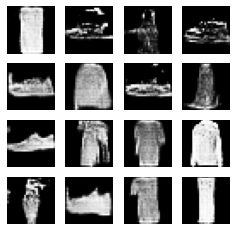

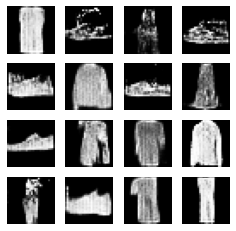

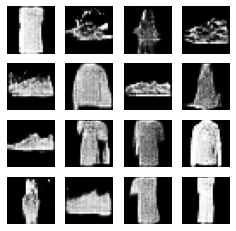

time epoch 90 is 13.258858919143677


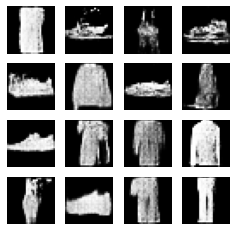

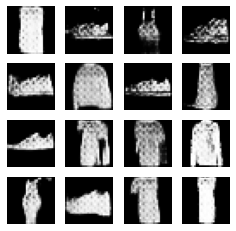

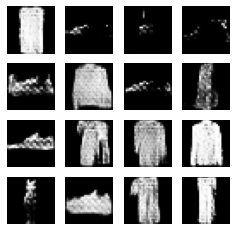

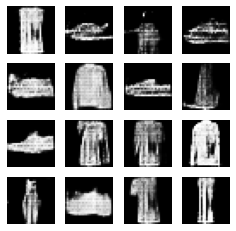

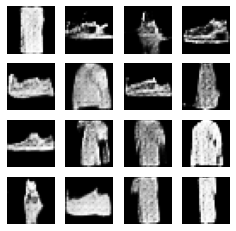

time epoch 95 is 13.229287147521973


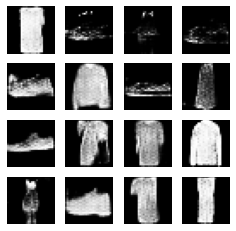

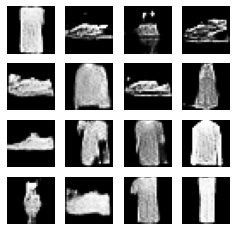

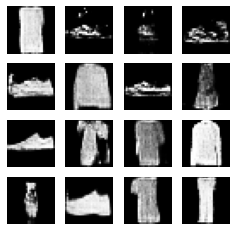

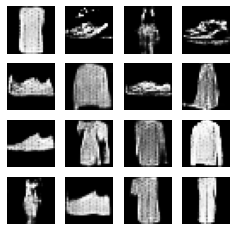

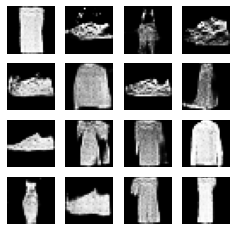

time epoch 100 is 13.11488151550293
CPU times: user 4min 56s, sys: 1min 2s, total: 5min 59s
Wall time: 21min 49s


In [10]:
%%time
train(train_dataset, epochs)


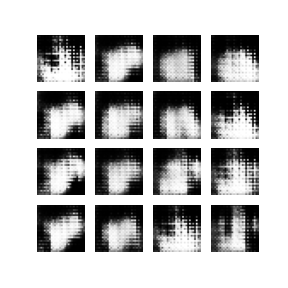

In [32]:
import imageio
from IPython.display import display,Image

anim_file = "dcgan.gif"
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("image*.png")
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2 *(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display(Image(filename=anim_file, format='png'))